In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

Проблема: Есть мнение, что “раньше снимали настоящее кино, не то что сейчас”. Ваша задача проверить это утверждение, используя файлы с рейтингами фильмов из прошлого домашнего занятия (файл ratings.csv из базы https://grouplens.org/datasets/movielens). Т. е. проверить верно ли, что с ростом года выпуска фильма его средний рейтинг становится ниже.

In [2]:
data_pd_movies = pd.read_csv('movies.csv')
data_pd_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
data_pd_movies.apply(len) # обратим внимание, что ID у нас в наличии 9125 уникальных штук

movieId    9125
title      9125
genres     9125
dtype: int64

Честно скажу, мне не очень понравился алгоритм, который предложен в задании (кроме того, решать задачу с подсказками скучно же), и я решил сделать все своим методом. Для начала я написал функцию, которая выдирает из корректно представленной строки год. Далее я попытался ее применить и понял, что она падает, естественно потому, что не везде строка корректна. Тогда я вспомнил всю фигню с обработкой ошибок и написал обработчик, теперь массив формируется корректно. 

In [4]:
def find_all_years(string):
    find_block = r'\(\d{4}\)'
    find_year = r'\d{4}'
    return int(re.search(find_year, re.search(find_block, string).group(0)).group(0))

Сначала я решил посмотреть на уникальные года и, заодно, на ошибоки парсинга

In [5]:
list_year = []
error_list = []
for index, row in data_pd_movies.iterrows():
    try:
        list_year.append(find_all_years(row['title']))
    except AttributeError:
        error_list.append(row['title'])

Таким образом, мы видим, что некорректно описанных фильмов очень мало и ими можно пренебречь. 

In [6]:
error_list

['Big Bang Theory, The (2007-)',
 'Fawlty Towers (1975-1979)',
 'Hyena Road',
 'The Lovers and the Despot',
 'Stranger Things',
 "Women of '69, Unboxed"]

In [7]:
# Также мы видим, что обзор охватывает фильмы с 1902 по 2016 год, при этом, после 1902 следут большой провал
unique_years = set(list_year)

In [8]:
# Теперь пройдемся по фрейму и обработаем его, записав вместо ошибок None 
year_dict = {}
for index, row in data_pd_movies.iterrows():
    try:
        year_dict.setdefault(index, find_all_years(row['title']))
    except AttributeError:
        year_dict.setdefault(index, None)
    
year_df = pd.DataFrame(year_dict.values(), columns=['years'])
data_pd_movies_years = pd.concat([data_pd_movies, year_df], axis=1)
data_pd_movies_years.head()
# Год, правда получился немного не в том формате, ну да бог с ним, число и число

,movieId,title,genres,years
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


Выкинем ненужные нам NaN

In [9]:
data_pd_movies_clean = data_pd_movies_years.dropna()

Теперь поколупаем рейтинги

In [10]:
data_pd_ratings = pd.read_csv('ratings.csv')
data_pd_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Подсчитаем все рейтинги,тупить будет довольно долго, с минуту где-то у меня, надо изучить способ ускорения

In [11]:
rating_dict = {}
for index, row in data_pd_ratings.iterrows():
    movieId = (data_pd_ratings['movieId'] == row['movieId'])
    data_pd_movieId = data_pd_ratings[movieId]
    movieId_sum = data_pd_movieId['rating'].sum()
    rating_dict.setdefault(int(row['movieId']), movieId_sum) 

In [12]:
len(rating_dict)

9724

Обратим внимание, что ID в ratings у нас в наличии 9724 уникальных штук, а в movies лишь 9119!

In [13]:
# Сделаем из словаря датафрейм
ratings_df = pd.DataFrame(rating_dict.items(), columns=['movieId', 'rating'])
ratings_df = ratings_df.astype({'movieId': np.int64}) # заодно конвертируем тип для совместимости с data_pd_movies
ratings_df.head(10)

,movieId,rating
0,1,843.0
1,3,169.5
2,6,402.5
3,47,807.0
4,50,864.5
5,70,193.0
6,101,87.0
7,110,955.5
8,151,156.0
9,157,31.5


Теперь сольем два датафрейма, выкинем лишние колонки и почистим от NaN-ов

In [30]:
ratings_years_df = ratings_df.merge(data_pd_movies_clean, how='outer').drop(new_df.columns[[2, 3]], axis='columns').dropna()
ratings_years_df

,movieId,rating,years
0,1,843.0,1995.0
1,3,169.5,1995.0
2,6,402.5,1995.0
3,47,807.0,1995.0
4,50,864.5,1995.0
...,...,...,...
9692,118082,3.5,2014.0
9694,129313,4.0,2014.0
9702,138610,1.5,2015.0
9706,140267,4.0,2015.0


Как видим, с ID у нас выходила знатная коллизия - не все ID из rating были в movies и, скорее всего, наоборот. Посмотрим быстренько, сколько ID из ratings у нас нет в movies:

In [37]:
list_test = []
for i in list(data_pd_movies_clean['movieId'].values):
    if i in list(ratings_df['movieId'].values):
        list_test.append(i)
len(list_test)

7071

Отлично, ответ совпадает, значит merge у нас все сделал правильно. В целом мне это сходу не интуитивно очевидно, так что я решил убедится. Остался последний вызов - подсчитать рейтинг годов!

In [45]:
# вот тут нам и пригодился наш unique_years, который мы нашли в самом начале. 
# легко можно обойтись и без него, но так немного прозрачнее, да и не пропадать же ему, раз уж нашли
rating_year_dict = {}
for year in unique_years:
    year_filter = (ratings_years_df['years'] == year)
    rating_df_filter =  ratings_years_df[year_filter]
    rating_year_sum = rating_df_filter['rating'].sum()
    rating_year_dict.setdefault(year, rating_year_sum) 

In [58]:
# функцию я честно слизал, разбираться с графиками в питоне пока не хотелось
def barplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots()
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

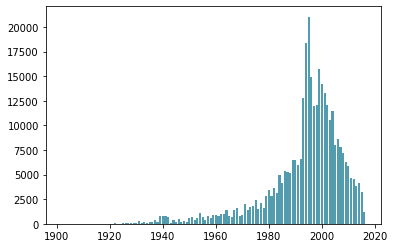

In [59]:
barplot(list(rating_year_dict.keys()), list(rating_year_dict.values()))

Вот оно, вожделенное распределение по годам! Однако, на практике оно совершенно бесполезно и дело совсем не в субъективности оценок, а совсем в другом. Беда в том, что лишь немногие, родившиеся в 80е смотрели фильмы, допустим, 60х, а те, кто родился в 50е и делал миллионные кассы фильмам 60х сейчас уже явно имеют много иных забот, нежели ходить по сайтам с оценками. Так что максимально адекватной оценкой качества фильма (ну, по крайней мере, его популярности) было бы взять приведенные с учетом инфляции кассы фильмов по годам (хотя бы те, что окупились), так картина была бы куда адекватнее. Кстати, не случайно пик "качества" фильмов на этой диаграмме приходится на 1995-2005 - просто даты рождения максимально активных пользователей на этом сайте, скорее всего - 1980-1990, очевидно, что большая часть из них не смотрела ничего в своей жизни, кроме блокбастеров своей молодости и детства. 

Однако, даже эти данные можно сделать адекватными. Для этого нужно всего лишь сделать приведенную оценку, то есть разделить балл фильмов за этот год на число человек, оставивших оценки в этом году.

In [64]:
data_pd_ratings.sort_values('userId').tail()

,userId,movieId,rating,timestamp
99963,610,6387,3.5,1479542038
99962,610,6383,2.5,1493846084
99961,610,6378,3.5,1493844983
99979,610,6708,3.5,1493847441
100835,610,170875,3.0,1493846415


Что же, неудивительно, что мы получили настолько кривое распределение, - оценки выставляло всего 610 человек!

In [74]:
votes_dict ={}
for index, row in data_pd_ratings.iterrows():
    movieId = (data_pd_ratings['movieId'] == row['movieId'])
    data_pd_ratings_movieId = data_pd_ratings[movieId]
    votes_sum = len(data_pd_ratings_movieId['userId'])
    votes_dict.setdefault(row['movieId'], votes_sum) 

In [75]:
# Сделаем из словаря датафрейм
votes_df = pd.DataFrame(votes_dict.items(), columns=['movieId', 'votes'])
votes_df = votes_df.astype({'movieId': np.int64}) # заодно конвертируем тип для совместимости с data_pd_movies
votes_df.head(10)

,movieId,votes
0,1,215
1,3,52
2,6,102
3,47,203
4,50,204
5,70,55
6,101,23
7,110,237
8,151,44
9,157,11


In [76]:
votes_years_df = votes_df.merge(data_pd_movies_clean, how='outer').drop(new_df.columns[[2, 3]], axis='columns').dropna()
votes_years_df

,movieId,votes,years
0,1,215.0,1995.0
1,3,52.0,1995.0
2,6,102.0,1995.0
3,47,203.0,1995.0
4,50,204.0,1995.0
...,...,...,...
9692,118082,1.0,2014.0
9694,129313,1.0,2014.0
9702,138610,1.0,2015.0
9706,140267,1.0,2015.0


In [81]:
votes_year_dict = {}
for year in unique_years:
    year_filter = (votes_years_df['years'] == year)
    votes_df_filter =  votes_years_df[year_filter]
    votes_year_sum = votes_df_filter['votes'].sum()
    votes_year_dict.setdefault(year, votes_year_sum)


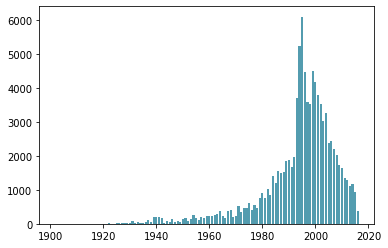

In [83]:
barplot(list(votes_year_dict.keys()), list(votes_year_dict.values()))

Итак, наше подозрение блестяще оправдалось. Давайте попробуем исправить этот бардак и получить хоть какие-то адекватные оценки

In [86]:
rating_year_df = pd.DataFrame(rating_year_dict.items(), columns=['year', 'rating'])
rating_year_df.head(10)

,year,rating
0,1902,17.5
1,1915,2.0
2,1916,11.0
3,1917,4.5
4,1918,0.0
5,1919,0.0
6,1920,27.0
7,1921,20.5
8,1922,56.5
9,1923,14.5


In [87]:
votes_year_df = pd.DataFrame(votes_year_dict.items(), columns=['year', 'votes'])
votes_year_df.head(10)

,year,votes
0,1902,5.0
1,1915,1.0
2,1916,3.0
3,1917,1.0
4,1918,0.0
5,1919,0.0
6,1920,7.0
7,1921,5.0
8,1922,16.0
9,1923,4.0


In [89]:
y_r_v_dataframe = rating_year_df.merge(votes_year_df)
y_r_v_dataframe

,year,rating,votes
0,1902,17.5,5.0
1,1915,2.0,1.0
2,1916,11.0,3.0
3,1917,4.5,1.0
4,1918,0.0,0.0
...,...,...,...
98,2012,4575.5,1299.0
99,2013,3837.5,1109.0
100,2014,4188.0,1187.0
101,2015,3222.0,934.0


In [93]:
y_r_v_dataframe['r/v'] = y_r_v_dataframe['rating'] / y_r_v_dataframe['votes']
y_r_v_dataframe.dropna()

,year,rating,votes,r/v
0,1902,17.5,5.0,3.500000
1,1915,2.0,1.0,2.000000
2,1916,11.0,3.0,3.666667
3,1917,4.5,1.0,4.500000
6,1920,27.0,7.0,3.857143
...,...,...,...,...
98,2012,4575.5,1299.0,3.522325
99,2013,3837.5,1109.0,3.460325
100,2014,4188.0,1187.0,3.528222
101,2015,3222.0,934.0,3.449679


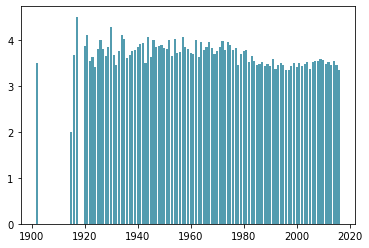

In [97]:
barplot(list(y_r_v_dataframe['year']), list(y_r_v_dataframe['r/v']))

О да, это уже куда больше похоже на правду!

In [108]:
y_r_v_dataframe_sort = y_r_v_dataframe.sort_values(by=['r/v'], ascending=False).dropna()
y_r_v_dataframe_sort.head(10)

,year,rating,votes,r/v
3,1917,4.5,1.0,4.500000
16,1930,64.0,15.0,4.266667
20,1934,127.5,31.0,4.112903
7,1921,20.5,5.0,4.100000
30,1944,357.5,88.0,4.062500
43,1957,843.0,208.0,4.052885
40,1954,1082.0,269.0,4.022305
21,1935,152.5,38.0,4.013158
12,1926,44.0,11.0,4.000000
38,1952,367.5,92.0,3.994565


In [109]:
y_r_v_dataframe_sort.tail(10)

,year,rating,votes,r/v
74,1988,5185.5,1512.0,3.429563
88,2002,12077.0,3525.0,3.426099
86,2000,14235.5,4182.0,3.403993
10,1924,17.0,5.0,3.400000
91,2005,7977.0,2366.0,3.371513
78,1992,6591.5,1957.0,3.368166
83,1997,12005.5,3584.0,3.349749
102,2016,1237.5,370.0,3.344595
82,1996,14911.5,4466.0,3.338894
1,1915,2.0,1.0,2.000000


Как видим, при таком подходе мы получаем ровно противоположную картину - крутейшие фильмы снимали с 1920х по 1950е годы, а в 2000х нет ничего, что могло бы с ними сравнится. На самом деле это тоже легко объяснить, но уже, как раз, субъективным перекосом. Очевидно, что фильмы 20-30х годов смотрели только редкие эстеты, очевидно, что раз уж они добрались до такой бородатой классики, то, скорее всего, оценят ее высоко.